In [2]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from google_play_scraper import reviews
from app_store_scraper import AppStore
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
import string
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments




# Scraping des avis Google Play Store pour différentes régions

Ce code permet de récupérer les avis pour une application spécifique depuis le Google Play Store pour plusieurs pays, puis de les organiser dans un DataFrame pandas.

## Étapes du processus :

1. **Définition des paramètres** : Nous avons sélectionné plusieurs pays (`us`, `fr`, `de`) et spécifié l'identifiant de l'application pour Pokémon Trading Card Game (`jp.pokemon.pokemontcgp`).

2. **Récupération des avis** : Pour chaque pays, nous utilisons la fonction `reviews()` pour obtenir les avis de l'application spécifiée. Nous avons choisi de récupérer jusqu'à 100 000 avis par pays.

3. **Stockage des données** : Les avis récupérés sont ajoutés à une liste `all_google_reviews` avec le pays d'origine pour chaque avis.

4. **Conversion en DataFrame** : Après avoir collecté tous les avis, nous les convertissons en un DataFrame pandas pour une analyse plus facile.

In [3]:
countries = ["us", "fr", "de"]
app_id_google = 'jp.pokemon.pokemontcgp'

# Listes pour accumuler les données
all_google_reviews = []


# Scraper les avis pour chaque pays
for country in countries:
    # Google Play Store
    print(f"Scraping Google Play Store pour le pays : {country}")
    result, _ = reviews(
        app_id_google,
        lang="en",  # Spécifiez "en" pour la langue anglaise ou ajustez si nécessaire
        country=country,
        count=100000 # Un nombre plus élevé de résultats
    )
    for review in result:
        review['Pays']= country
        all_google_reviews.append(review)
        
    
    print(f"{len(result)} avis récupérés pour Google Play Store")

   

# Convertir les données en DataFrame
google_df = pd.DataFrame(all_google_reviews)


print("Scraping terminé.")



Scraping Google Play Store pour le pays : us
31506 avis récupérés pour Google Play Store
Scraping Google Play Store pour le pays : fr
31506 avis récupérés pour Google Play Store
Scraping Google Play Store pour le pays : de
31506 avis récupérés pour Google Play Store
Scraping terminé.


# Nettoyage des données et sauvegarde des avis Google Play

Dans cette étape, nous nettoyons et préparons les données récupérées pour l'exportation dans un fichier CSV.

## Étapes du processus :

1. **Ajout de la colonne "Provenance"** : Une nouvelle colonne est ajoutée pour indiquer que les avis proviennent de Google Play Store.

2. **Suppression des colonnes inutiles** : Certaines colonnes, comme les informations sur l'utilisateur, les votes, et les réponses, sont supprimées pour garder les données pertinentes.

3. **Suppression des doublons** : Les doublons sont supprimés.

4. **Renommage des** : La colonne contenant la date des avis est renommée pour un nom plus lisible (`date`).

5. **Exportation en CSV** : Le DataFrame est sauvegarder dans un fichier CSV  `google_reviews.csv`.


In [4]:

# Ajouter la colonne de provenance
google_df["Provenance"] = "Google Play"

#suppression des colonnes inutiles
google_df_clean = google_df.drop(columns=["userName", "userImage","thumbsUpCount","replyContent","repliedAt","reviewId","reviewCreatedVersion"], errors="ignore")
google_df_clean = google_df_clean.drop_duplicates()
google_df_clean.rename(columns={'at': 'date'}, inplace=True)

google_df_clean.to_csv("export/google_reviews.csv", index=False)
display(google_df_clean)

,content,score,date,appVersion,Pays,Provenance
0,kinda fun. needs more cards,4,2024-12-11 16:37:20,1.0.9,us,Google Play
1,p2w die hard game,1,2024-12-11 16:22:26,1.0.9,us,Google Play
2,po su kare,5,2024-12-11 16:16:28,1.0.9,us,Google Play
3,"I'll go right to the main issue, the booster p...",1,2024-12-11 16:15:22,1.0.9,us,Google Play
4,There's no way the coin flips are 50/50 the am...,1,2024-12-11 16:08:28,1.0.9,us,Google Play
...,...,...,...,...,...,...
94513,"Cool, but it's already bugged out. Didn't get ...",2,2024-09-26 03:56:36,1.0.2,de,Google Play
94514,Seems pretty slick from the first few hours. S...,4,2024-09-26 03:26:44,1.0.2,de,Google Play
94515,Early daya,3,2024-09-26 03:12:18,1.0.2,de,Google Play
94516,Doesn't work,1,2024-09-26 02:39:12,1.0.2,de,Google Play


# Récupération des avis depuis l'App Store

Cette étape permet de récupérer les avis pour une application spécifique depuis l'App Store pour plusieurs pays et de les enregistrer dans un fichier CSV.

## Étapes du processus :

1. **Définition des paramètres** : Nous avons spécifié l'identifiant de l'application sur l'App Store (`6479970832`), les pays à cibler (`fr`, `de`, `us`), et le nombre d'avis par requête (500).

2. **Scraping des avis** : Pour chaque pays, nous utilisons la bibliothèque `AppStore` pour récupérer les avis. Les avis sont ajoutés à une liste avec une colonne supplémentaire pour indiquer le pays d'origine.

3. **Conversion en DataFrame** : Les avis récupérés sont convertis en un DataFrame pandas.

4. **Exportation des données** : Le DataFrame est ensuite exporté dans un fichier CSV nommé `apple_reviews.csv`.


In [5]:
# Configuration
app_id_app_store = 6479970832
countries = ["fr", "de",'us']  # Liste des pays à cibler
batch_size = 500  # Nombre d'avis par requête
all_app_store_reviews = []
 
# Scraping pour chaque pays
for country in countries:
    print(f"Scraping App Store pour le pays : {country}")
    app = AppStore(country=country, app_name="le-jcc-pokemon-pocket", app_id=app_id_app_store)
    app.review(how_many=batch_size)

    for review in app.reviews:
        review['Pays'] = country
        all_app_store_reviews.append(review)
        
# Convertir en DataFrame et enregistrer
app_store_df = pd.DataFrame(all_app_store_reviews)
print("Scraping terminé.")
app_store_df.to_csv("export/apple_reviews.csv", index=False)

Scraping App Store pour le pays : fr


2024-12-12 16:42:04,481 [INFO] Base - Initialised: AppStore('fr', 'le-jcc-pokemon-pocket', 6479970832)
2024-12-12 16:42:04,483 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/fr/app/le-jcc-pokemon-pocket/id6479970832
2024-12-12 16:42:09,938 [INFO] Base - [id:6479970832] Fetched 400 reviews (400 fetched in total)
2024-12-12 16:42:11,203 [INFO] Base - [id:6479970832] Fetched 500 reviews (500 fetched in total)


Scraping App Store pour le pays : de


2024-12-12 16:42:11,988 [INFO] Base - Initialised: AppStore('de', 'le-jcc-pokemon-pocket', 6479970832)
2024-12-12 16:42:11,989 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/de/app/le-jcc-pokemon-pocket/id6479970832
2024-12-12 16:42:17,055 [INFO] Base - [id:6479970832] Fetched 440 reviews (440 fetched in total)
2024-12-12 16:42:17,744 [INFO] Base - [id:6479970832] Fetched 500 reviews (500 fetched in total)


Scraping App Store pour le pays : us


2024-12-12 16:42:18,545 [INFO] Base - Initialised: AppStore('us', 'le-jcc-pokemon-pocket', 6479970832)
2024-12-12 16:42:18,546 [INFO] Base - Ready to fetch reviews from: https://apps.apple.com/us/app/le-jcc-pokemon-pocket/id6479970832
2024-12-12 16:42:23,749 [INFO] Base - [id:6479970832] Fetched 400 reviews (400 fetched in total)
2024-12-12 16:42:24,990 [INFO] Base - [id:6479970832] Fetched 500 reviews (500 fetched in total)


Scraping terminé.


In [6]:
display(app_store_df)

,date,review,rating,isEdited,title,userName,Pays
0,2024-11-01 08:45:43,"Le jeu est incroyable, plus besoin de payer co...",5,False,Merci de nous faire retomber en enfance ❤️,Tot03869,fr
1,2024-11-03 14:22:52,"Bonjour,\nCe jeu de carte pokemon est presque ...",4,False,Top mais quelques bugs a corriger,Killking,fr
2,2024-11-12 09:25:18,"Très bon jeu de deck building, ou de carte à c...",5,False,Jeu excellent,GngCll12,fr
3,2024-10-30 03:13:13,nous pouvons ouvrir jusqu’à deux boosters/jour...,5,False,Rien à redire,Heymilyyy,fr
4,2024-11-22 07:37:11,"Merci pour ce jeu vraiment, incroyable. Par co...",4,False,Très bon mais peu être améliorer,viitany,fr
...,...,...,...,...,...,...,...
1495,2024-11-04 18:52:51,"Like other pay to win games, the battle system...",1,False,Unbalanced Battle System,Dartang,us
1496,2024-12-08 18:07:45,Calling the number generator when facing AI ra...,1,False,RNG vs AI needs to be random,Pocketsisbad,us
1497,2024-11-22 19:37:56,"The game is fantastic, from design to mechanic...",4,False,Matchmaking,Tnite715,us
1498,2024-11-14 23:34:59,Right now there’s a handful of infuriating met...,3,False,It’s good but why even bother?,screwbots,us


# Nettoyage des données des avis App Store

Dans cette étape, nous nettoyons et préparons les avis récupérés depuis l'App Store.

## Étapes du processus :

1. **Suppression des doublons** : Les doublons dans le DataFrame sont supprimés pour ne garder que les avis uniques.

2. **Suppression des colonnes inutiles** : Certaines colonnes comme `isEdited`, `userName`, et `title` sont supprimées, car elles ne sont pas nécessaires pour l'analyse.

3. **Ajout de la colonne "Provenance"** : Une nouvelle colonne est ajoutée pour indiquer que les avis proviennent de l'Apple Store.

4. **Renommage des colonnes** : Les colonnes `review` et `rating` sont renommées respectivement en `content` et `score` pour fussioner le data frame avec les commentaires google précédents.


In [8]:

df_apple_csv_all = app_store_df.drop_duplicates()

df_apple_csv_all = df_apple_csv_all.drop(columns=["isEdited","userName","title"])

df_apple_csv_all["Provenance"] = "Apple Store"

df_apple_csv_all.rename(columns={'review': 'content','rating':'score'}, inplace=True)
# Afficher le DataFrame final
display(df_apple_csv_all)

,date,content,score,Pays,Provenance
0,2024-11-01 08:45:43,"Le jeu est incroyable, plus besoin de payer co...",5,fr,Apple Store
1,2024-11-03 14:22:52,"Bonjour,\nCe jeu de carte pokemon est presque ...",4,fr,Apple Store
2,2024-11-12 09:25:18,"Très bon jeu de deck building, ou de carte à c...",5,fr,Apple Store
3,2024-10-30 03:13:13,nous pouvons ouvrir jusqu’à deux boosters/jour...,5,fr,Apple Store
4,2024-11-22 07:37:11,"Merci pour ce jeu vraiment, incroyable. Par co...",4,fr,Apple Store
...,...,...,...,...,...
1495,2024-11-04 18:52:51,"Like other pay to win games, the battle system...",1,us,Apple Store
1496,2024-12-08 18:07:45,Calling the number generator when facing AI ra...,1,us,Apple Store
1497,2024-11-22 19:37:56,"The game is fantastic, from design to mechanic...",4,us,Apple Store
1498,2024-11-14 23:34:59,Right now there’s a handful of infuriating met...,3,us,Apple Store


# Sélection aléatoire d'un échantillon et préparation des données

Dans cette étape, nous créons un échantillon aléatoire de 2000 avis combinant les avis de Google Play et de l'Apple Store, puis nous préparons les données pour l'exportation.

## Étapes du processus :

1. **Sélection aléatoire de 1000 avis Google Play** : Nous sélectionnons aléatoirement 1000 avis du DataFrame `google_df_clean` en utilisant la méthode `sample()`. Le paramètre `random_state` garantit la reproductibilité de la sélection.

2. **Fusion des avis de Google Play et Apple Store** : Nous concaténons les 1000 premiers avis d'Apple Store (`df_apple_csv_all.head(1000)`) avec l'échantillon de 1000 avis de Google Play.

3. **Conversion de la colonne "date" en format datetime** : La colonne `date` est convertie en format `datetime` pour faciliter la manipulation des dates sur tableau , puis reformattée en `YYYY-MM-DD` car nous n'utiliserons pas les heures, minutes, secondes.

4. **Exportation en CSV** : Le DataFrame combiné est ensuite exporté dans un fichier CSV pour être utilisé dans des analyses futures.


In [9]:

# Sélection aléatoire de 2000 lignes
sampled_df_google = google_df_clean.sample(n=1000, random_state=892)  # random_state pour garantir la reproductibilité
sampled_df_all = pd.concat([sampled_df_google,df_apple_csv_all.head(1000)], ignore_index=True)


sampled_df_all['date'] = pd.to_datetime(sampled_df_all['date'])  
sampled_df_all['date'] = sampled_df_all['date'].dt.strftime('%Y-%m-%d')

display(sampled_df_all)
sampled_df_all.to_csv('export/sampled_reviews.csv', index=False)

sampled_pour_roberta = sampled_df_all[['content', 'Pays', 'Provenance']]
sampled_pour_roberta.to_csv('export/sampled_pour_roberta.csv', index=False)



,content,score,date,appVersion,Pays,Provenance
0,Lol these games on google play are starting to...,1,2024-12-11,1.0.9,us,Google Play
1,"amazing, please put a similar battle system fo...",5,2024-10-31,1.0.5,us,Google Play
2,This game would honestly be a bit more fun if ...,1,2024-11-08,1.0.6,us,Google Play
3,alternate for formal TCG,5,2024-11-09,1.0.6,us,Google Play
4,"Won 4 in a row, lost 5 to bad luck, have to st...",1,2024-12-09,1.0.9,de,Google Play
...,...,...,...,...,...,...
1995,Kurz:\nBooster zu limitiert. Kämpfe vor allem ...,1,2024-11-08,NaN,de,Apple Store
1996,Der Shop bzw. die Wunderwahl ist so ausgelegt ...,1,2024-11-21,NaN,de,Apple Store
1997,Erst bei den Anfänger Matches und sehe schon 2...,1,2024-11-12,NaN,de,Apple Store
1998,Pokémon hat mal wieder eine unvollständige App...,1,2024-11-04,NaN,de,Apple Store


# Fusion des avis Google Play et Apple Store

Dans cette étape, nous fusionnons les avis provenant de l'Apple Store et de Google Play pour créer un DataFrame combiné qui sera utilisé pour l'entraînement du modèle et la création d'un nuage de mots.

## Étapes du processus :

1. **Fusion des DataFrames** : Nous concaténons verticalement les DataFrames `df_apple_csv_all` et `google_df_clean` à l'aide de `pd.concat()`. Cela combine tous les avis dans un seul DataFrame.

2. **Conversion de la colonne "date" en format datetime** : La colonne `date` est convertie en format `datetime` pour une manipulation plus facile, puis reformattée en `YYYY-MM-DD`.

3. **Exportation des données fusionnées** : Le DataFrame fusionné est exporté dans un fichier CSV nommé `all_reviews.csv` pour une utilisation ultérieure.




In [10]:
# Concaténation verticale des deux DataFrames
df_merged = pd.concat([df_apple_csv_all, google_df_clean], ignore_index=True)

df_merged['date'] = pd.to_datetime(df_merged['date'])  
df_merged['date'] = df_merged['date'].dt.strftime('%Y-%m-%d')

display(df_merged)
df_merged.to_csv('export/all_reviews.csv', index=False)

,date,content,score,Pays,Provenance,appVersion
0,2024-11-01,"Le jeu est incroyable, plus besoin de payer co...",5,fr,Apple Store,NaN
1,2024-11-03,"Bonjour,\nCe jeu de carte pokemon est presque ...",4,fr,Apple Store,NaN
2,2024-11-12,"Très bon jeu de deck building, ou de carte à c...",5,fr,Apple Store,NaN
3,2024-10-30,nous pouvons ouvrir jusqu’à deux boosters/jour...,5,fr,Apple Store,NaN
4,2024-11-22,"Merci pour ce jeu vraiment, incroyable. Par co...",4,fr,Apple Store,NaN
...,...,...,...,...,...,...
96013,2024-09-26,"Cool, but it's already bugged out. Didn't get ...",2,de,Google Play,1.0.2
96014,2024-09-26,Seems pretty slick from the first few hours. S...,4,de,Google Play,1.0.2
96015,2024-09-26,Early daya,3,de,Google Play,1.0.2
96016,2024-09-26,Doesn't work,1,de,Google Play,1.0.2


# Création d'un nuage de mots à partir des avis

Dans cette étape, nous générons un nuage de mots à partir des commentaires collectés. Cela permet de visualiser les termes les plus fréquents et d'identifier les mots-clés des avis des utilisateurs.

## Étapes du processus :

1. **Préparation des commentaires** : Tous les commentaires des utilisateurs (colonne `content` du DataFrame `google_df_clean`) sont combinés en une seule chaîne de texte, avec les valeurs manquantes ignorées grâce à `dropna()`.

2. **Création du nuage de mots** : Nous utilisons la bibliothèque `WordCloud` pour générer un nuage de mots.

3. **Affichage du nuage de mots** : Le nuage de mots est affiché à l'aide de `matplotlib`.

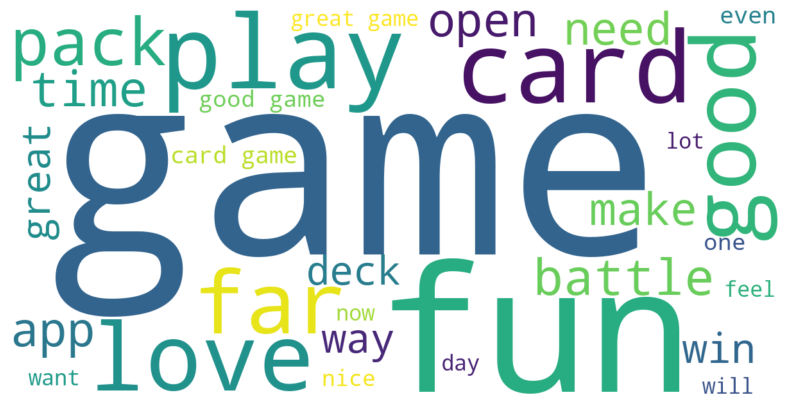

In [11]:

all_comments = ' '.join(google_df_clean['content'].dropna())

# Créer le nuage de mots
wordcloud = WordCloud(
    width=1200,                  # Largeur de l'image
    height=600,                 # Hauteur de l'image
    max_words=30,               # Nombre maximum de mots à afficher 
    background_color="white",   # Couleur de fond
    colormap="viridis"          # Palette de couleurs
).generate(all_comments)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))    # Taille de la figure
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")                # Masquer les axes
plt.show()



In [13]:
# Importations des avis PlayStore et AppStore
df = df_merged
display(df)

,date,content,score,Pays,Provenance,appVersion
0,2024-11-01,"Le jeu est incroyable, plus besoin de payer co...",5,fr,Apple Store,NaN
1,2024-11-03,"Bonjour,\nCe jeu de carte pokemon est presque ...",4,fr,Apple Store,NaN
2,2024-11-12,"Très bon jeu de deck building, ou de carte à c...",5,fr,Apple Store,NaN
3,2024-10-30,nous pouvons ouvrir jusqu’à deux boosters/jour...,5,fr,Apple Store,NaN
4,2024-11-22,"Merci pour ce jeu vraiment, incroyable. Par co...",4,fr,Apple Store,NaN
...,...,...,...,...,...,...
96013,2024-09-26,"Cool, but it's already bugged out. Didn't get ...",2,de,Google Play,1.0.2
96014,2024-09-26,Seems pretty slick from the first few hours. S...,4,de,Google Play,1.0.2
96015,2024-09-26,Early daya,3,de,Google Play,1.0.2
96016,2024-09-26,Doesn't work,1,de,Google Play,1.0.2


# **I - Préparation des données**

In [14]:
# Prétraiter les données
df['content'] = df['content'].str.lower().str.replace('[^\w\s]', '', regex=True)

# Diviser les données en train et test
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['score'], test_size=0.2, random_state=2)


# Oon créée le modèle avec les poids de classe calculés
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

#Utilisation de nltk afin de considérer non seulement des mots individuels, mais aussi des paires de mots consécutifs
nltk.download('stopwords')
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words=stopwords.words('english'))

# On transforme les données textuelles en vecteurs
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
C:\Users\potet\AppData\Local\Temp\ipykernel_14160\1386879232.py:2: SyntaxWarning: invalid escape sequence '\w'
  df['content'] = df['content'].str.lower().str.replace('[^\w\s]', '', regex=True)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\potet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **II - Création, entrainement du modèle et prédictions**

In [15]:
model = LogisticRegression(max_iter=10000, class_weight=class_weight_dict)

# Entrainement du modèle
model.fit(X_train_tfidf, y_train)

# On calcule l'erreur quadratique moyenne
y_pred = model.predict(X_test_tfidf)
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne: {mse}")

#Prédiction
X_avis = vectorizer.transform(df['content'])
notes_prévues = model.predict(X_avis)
df['notes_calculees'] = notes_prévues
df.head(100)

Erreur quadratique moyenne: 0.44147052697354716


,date,content,score,Pays,Provenance,appVersion,notes_calculees
0,2024-11-01,le jeu est incroyable plus besoin de payer com...,5,fr,Apple Store,NaN,3
1,2024-11-03,bonjour\nce jeu de carte pokemon est presque p...,4,fr,Apple Store,NaN,4
2,2024-11-12,très bon jeu de deck building ou de carte à co...,5,fr,Apple Store,NaN,3
3,2024-10-30,nous pouvons ouvrir jusquà deux boostersjour g...,5,fr,Apple Store,NaN,3
4,2024-11-22,merci pour ce jeu vraiment incroyable par cont...,4,fr,Apple Store,NaN,3
...,...,...,...,...,...,...,...
95,2024-11-04,très bon jeu mais revoir le système de fram po...,5,fr,Apple Store,NaN,3
96,2024-10-30,clairement le jeu que tous les passionnés de c...,4,fr,Apple Store,NaN,3
97,2024-11-15,manque le mode sombre,5,fr,Apple Store,NaN,5
98,2024-11-06,jeu de collection de carte mélanger avec des c...,5,fr,Apple Store,NaN,4
